# Assessment of the SST climatology and its variability
### *Does these datasets provide a reliable representation of SST climatology and its variability?*
This notebook aims at evaluating the reliability and representativeness of sea surface temperature (SST) climatology and its variability in satellite-based long-term climate data records (CDRs). 
To this end, two different SST CDRs have been intercompared on a common 30-year (1982-2011) period. These datasets, available from the CADS, are the following:
- Sea surface temperature daily gridded data from 1981 to 2016 derived from a multi-product satellite-based ensemble - from the Group for High Resolution Sea Surface Temperature (GHRSST) multi-product ensemble (GMPE) produced by the European Space Agency SST Climate Change Initiative (ESA SST CCI) (GMPE in the following);
- Sea Surface Temperature daily data from 1981 to present derived from satellite observations, ESA CCI SST Level-4 dataset v2.1 (ESA CCI SST in the following);
#### **Main Takeaways - Assessment outcomes in a nutshell**
1. Both datasets provide consistent results, well reproducing SST mean values and the main patterns of SST variability on a variety of scales, ranging from seasonal to (multi-)annual time scales;
2. Both datasets can be exploited for climate studies;
3. Northern / Southern Hemisphere spatially averaged SST annual cycles have an amplitude of 3.51°C/2.17°C for GMPE and 3.53°C/2.26°C for ESA-CCI. This is in agreement with observation-based studies published in the scientific literature;

## Import packages

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import tqdm
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils

plt.style.use("seaborn-v0_8-notebook")

## Define Parameters

In [2]:
# Time
year_start = 1982
year_stop = 2011

# Regions
regions = {
    "northern hemisphere": {"lon_slice": slice(-180, 180), "lat_slice": slice(0, 90)},
    "southern hemisphere": {"lon_slice": slice(-180, 180), "lat_slice": slice(-90, 0)},
}

## Define Parameters

In [3]:
# Requests
request_dicts = {
    "ESACCI": {
        "collection_id": "satellite-sea-surface-temperature",
        "request": {
            "processinglevel": "level_4",
            "format": "zip",
            "variable": "all",
            "sensor_on_satellite": "combined_product",
            "version": "2_1",
        },
        "chunks": {"year": 1, "month": 1},
    },
    "GMPE": {
        "collection_id": "satellite-sea-surface-temperature-ensemble-product",
        "request": {
            "format": "zip",
            "variable": "all",
        },
        "chunks": {"year": 1, "month": 1, "day": 12},  # CDS limit is 12
    },
}

# Parameters to speed up I/O
open_mfdataset_kwargs = {
    "concat_dim": "time",
    "combine": "nested",
    "data_vars": "minimal",
    "coords": "minimal",
    "compat": "override",
    "parallel": True,
}

## Functions to cache

In [4]:
def get_masked_sst(ds):
    da = ds["analysed_sst"]
    if "mask" in ds:
        da = da.where(ds["mask"] == 1)
    with xr.set_options(keep_attrs=True):
        da -= 273.15
    da.attrs["units"] = "°C"
    return da


def add_chunksizes(da):
    da.encoding["chunksizes"] = tuple(map(max, da.chunks))
    return da


def rechunk(obj):
    """Use NetCDF chunks."""
    chunks = {"time": 1, "year": 1, "season": 1, "latitude": 1_200, "longitude": 2_400}
    obj = obj.chunk(
        **{dim: chunksize for dim, chunksize in chunks.items() if dim in obj.dims}
    )
    if isinstance(obj, xr.DataArray):
        return add_chunksizes(obj)
    for da in obj.data_vars.values():
        add_chunksizes(da)
    return obj


def compute_time_reductions(ds, func, **kwargs):
    ds = rechunk(ds)
    da = get_masked_sst(ds)
    da_reduced = rechunk(func(da, **kwargs))
    if "season" in da_reduced.dims:
        da_reduced = da_reduced.sel(season=sorted(set(da["time"].dt.season.values)))
    return rechunk(da_reduced).to_dataset()


def compute_spatial_weighted_reductions(ds, reduction, lon_slice, lat_slice):
    ds = rechunk(ds)
    ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)
    da = get_masked_sst(ds)
    da = diagnostics.spatial_weighted_mean(da, weights=True).compute()
    grouped = da.groupby("time.dayofyear")
    func = getattr(grouped, reduction)
    da_reduced = func("time", keep_attrs=True)
    return rechunk(da_reduced).to_dataset()

## Download and transform

In [5]:
# Settings
reductions = ("mean", "std")
season_month_dict = {
    "DJF": {"12", "01", "02"},
    "MAM": {"03", "04", "05"},
    "JJA": {"06", "07", "08"},
    "SON": {"09", "10", "11"},
}
start = f"{year_start-1}-12"
stop = f"{year_stop}-11"

# Initialize variables
datasets_annual = {}
datasets_seasonal = {}
timeseries_ds_list = []
for product, request_dict in request_dicts.items():
    kwargs = {
        "collection_id": request_dict["collection_id"],
        "transform_chunks": False,
        "chunks": request_dict["chunks"],
        **open_mfdataset_kwargs,
    }

    # Annual
    print(f"{product=}")
    annual_ds_list = []
    for year in tqdm.tqdm(range(year_start, year_stop + 1), desc="annual"):
        # Note: year from December year-1 to November year
        annual_requests = download.update_request_date(
            request_dict["request"],
            start=f"{year-1}-12",
            stop=f"{year}-11",
            stringify_dates=True,
        )
        tmp_ds_list = []
        for reduction in reductions:
            func = getattr(diagnostics, f"time_weighted_{reduction}")
            ds = download.download_and_transform(
                **kwargs,
                requests=annual_requests,
                transform_func=compute_time_reductions,
                transform_func_kwargs={"func": func, "weights": False},
            )
            tmp_ds_list.append(rechunk(ds).expand_dims(reduction=[reduction]))
        annual_ds_list.append(
            xr.concat(tmp_ds_list, "reduction").expand_dims(year=[year])
        )
    datasets_annual[product] = xr.concat(annual_ds_list, "year")

    # Seasonal and spatial
    requests = download.update_request_date(
        request_dict["request"],
        start=f"{year_start}-01",
        stop=f"{year_stop}-12",
        stringify_dates=True,
    )

    seasonal_ds_list = []
    for reduction in reductions:
        # Spatial
        print(f"{product=} {reduction=}")
        for region, slices in tqdm.tqdm(regions.items(), desc="region"):
            ds = download.download_and_transform(
                **kwargs,
                requests=requests,
                transform_func=compute_spatial_weighted_reductions,
                transform_func_kwargs={"reduction": reduction} | slices,
            )
            timeseries_ds_list.append(
                ds.expand_dims(
                    product=[product], reduction=[reduction], region=[region]
                )
            )

        # Seasonal
        func = getattr(diagnostics, f"seasonal_weighted_{reduction}")
        tmp_ds_list = []
        for season, months in tqdm.tqdm(season_month_dict.items(), desc="season"):
            season_requests = [
                {
                    k: v
                    if k != "month"
                    else sorted(set({v} if isinstance(v, str) else v) & months)
                    for k, v in r.items()
                }
                for r in requests
            ]
            ds = download.download_and_transform(
                **kwargs,
                requests=season_requests,
                transform_func=compute_time_reductions,
                transform_func_kwargs={"func": func, "weights": False},
            )
            tmp_ds_list.append(rechunk(ds))
        seasonal_ds_list.append(
            xr.concat(tmp_ds_list, "season").expand_dims(reduction=[reduction])
        )
    datasets_seasonal[product] = xr.concat(seasonal_ds_list, "reduction")

ds_timeseries = xr.merge(timeseries_ds_list)
del tmp_ds_list, annual_ds_list, seasonal_ds_list, timeseries_ds_list

product='ESACCI'


annual: 100%|██████████| 30/30 [00:19<00:00,  1.58it/s]


product='ESACCI' reduction='mean'


season: 100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


product='ESACCI' reduction='std'


season: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


product='GMPE'


annual: 100%|██████████| 30/30 [00:10<00:00,  2.81it/s]


product='GMPE' reduction='mean'


season: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


product='GMPE' reduction='std'


season: 100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


## Plot low resolution annual maps

In [6]:
datasets = []
for product, ds in datasets_annual.items():
    if product == "ESACCI":
        ds = ds.coarsen(latitude=5, longitude=5).mean()
        ds["latitude"] = ds["latitude"].round(3)
        ds["longitude"] = ds["longitude"].round(3)
    datasets.append(ds.expand_dims(product=[product]))
ds = xr.concat(datasets, "product")

In [7]:
ds_annual_low_res = ds.sel(reduction="mean")
datasets = []
for reduction in ("mean", "std"):
    ds = getattr(ds_annual_low_res, reduction)("year", keep_attrs=True)
    datasets.append(ds.expand_dims(reduction=[reduction]))
ds = xr.concat(datasets, "reduction")

In [8]:
import numpy as np
#Print global averaged SST
ds_mean = ds.sel(reduction="mean")
globavg_SST = ds_mean.weighted(np.cos(ds_mean.latitude*np.pi/180.)).mean(['latitude', 'longitude'])
for prod in globavg_SST.product:
    print(globavg_SST.sel(product=prod).compute())

<xarray.Dataset>
Dimensions:       ()
Coordinates:
    reduction     <U4 'mean'
    product       <U6 'ESACCI'
Data variables:
    analysed_sst  float32 18.39
<xarray.Dataset>
Dimensions:       ()
Coordinates:
    reduction     <U4 'mean'
    product       <U4 'GMPE'
Data variables:
    analysed_sst  float32 18.46


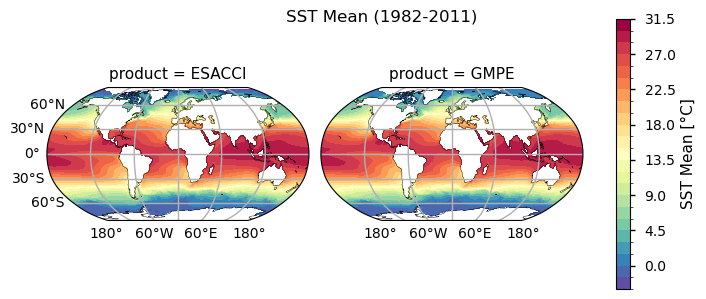

/data/common/mambaforge/envs/wp5/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/data/common/mambaforge/envs/wp5/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


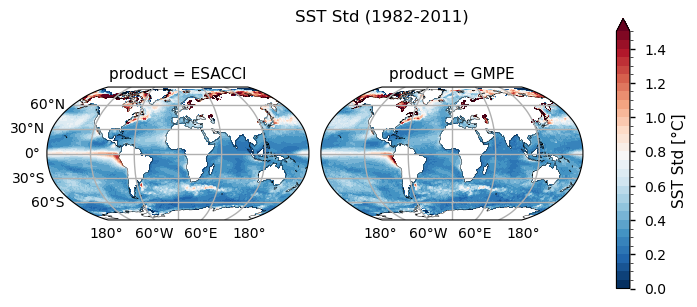

In [9]:
for reduction, da in ds["analysed_sst"].groupby("reduction"):
    title = f"SST {reduction.title()} ({year_start}-{year_stop})"
    kwargs = {"projection": ccrs.Robinson(), "plot_func": "contourf", "cbar_kwargs": {'label':f"SST {reduction.title()} [{da.attrs['units']}]"}}

    # Reduction
    plot.projected_map(
        da.squeeze(),
        cmap="Spectral_r" if reduction == "mean" else "RdBu_r",
        center=False,
        levels=31,
        vmin=0.0 if reduction=="std" else None,
        vmax=1.5 if reduction=="std" else None,
        col="product",
        #row='year',
        **kwargs,
    )
    plt.suptitle(title)
    plt.show()
    

The global distribution of the mean SST during the complete 30 years from 1982 to 2011 is shown in the top panel. The climatology correctly reveals the dominant latitudinal spatial SST pattern: higher at the tropics, milder at middle latitudes and lower in the polar regions (see, e.g., Deser et al., 2010). The globally averaged SST value is estimated in 18.39  0.40 °C in ESA CCI and  18.46  0.38 °C in GMPE.
The standard deviation map of annual mean SST is shown in the bottom panel. The annual average removes the seasonal variability and better quantifies the magnitude and spatial distribution of the nonseasonal SST variability. The standard deviation map evidences some patterns of the main current systems such as the Gulf Current and the Kuroshio Current, as well as regions such El-Nino in the tropical pacific, where the SST anomaly standard deviation exceeds 1.5°C. The main upwelling systems as, e.g., Perou-Chili, Benguela, NW-African coast and along the southern Saudi Arabia coast are also evident, as well as regions of strong mixing, like the Antarctic Circumpolar Current and the Aguhlas Leakage.

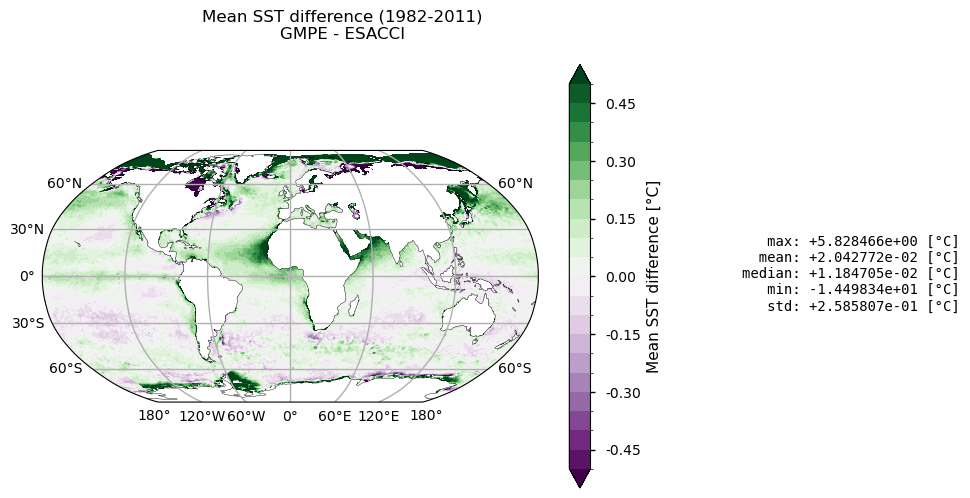

/data/common/mambaforge/envs/wp5/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/data/common/mambaforge/envs/wp5/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/data/common/mambaforge/envs/wp5/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/data/common/mambaforge/envs/wp5/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/data/common/mambaforge/envs/wp5/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/data/common/mambaforge/envs/wp5/lib/python3.10/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encount

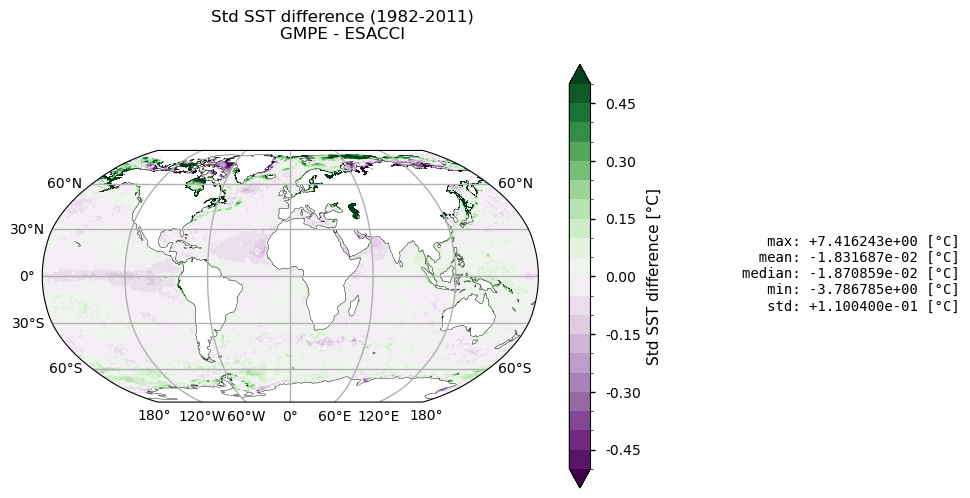

In [10]:
for reduction, da in ds["analysed_sst"].groupby("reduction"):
    # Bias
    with xr.set_options(keep_attrs=True):
        bias = da.diff("product").squeeze().chunk(dict(latitude=-1)).chunk(dict(longitude=-1)).squeeze()
        kwargs = {"projection": ccrs.Robinson(), "plot_func": "contourf", "cbar_kwargs": {'label':f"{reduction.title()} SST difference [{da.attrs['units']}]", 'format': '%.2f'}}
    plot.projected_map(
        bias, cmap="PRGn", center=False, levels=21, vmin=-.5, vmax=.5, **kwargs
    )
    title = f"{reduction.title()} SST difference ({year_start}-{year_stop})"
    plt.title('')
    plt.suptitle(title + "\n" + " - ".join(da["product"][::-1].values))
    plt.show()

Top panel depicts the difference between climatologies in GMPE and ESA CCI SSTs. The maximum value reached is about 5°C, especially under sea ice-covered regions in the Northern as well in the Southern Hemispheres. Overall, GMPE is about 0.02°C warmer on average than ESA CCI SST, as the map shows a positive pattern also around the tropical regions, and a slightly negative one around Aghulas, Gulf Stream and in the North Pacific.
The good agreement between ESA CCI and GMPE products is also confirmed by the difference in standard deviation (bottom panel), which shows values that are less than 0.1 °C over most of the global ocean. SST annual variability is slightly higher in ESA CCI than in GMPE over the tropical Pacific, the North Atlantic, the southern Saudi Arabia coast, and in the Agulhas system. The converse holds true in the Gulf Stream, Antarctic Circumpolar Current, and Indonesian Throughflow, resulting in GMPE having a variance close to 0.2°C greater than the one in ESA CCI.

## Plot low resolution seasonal maps

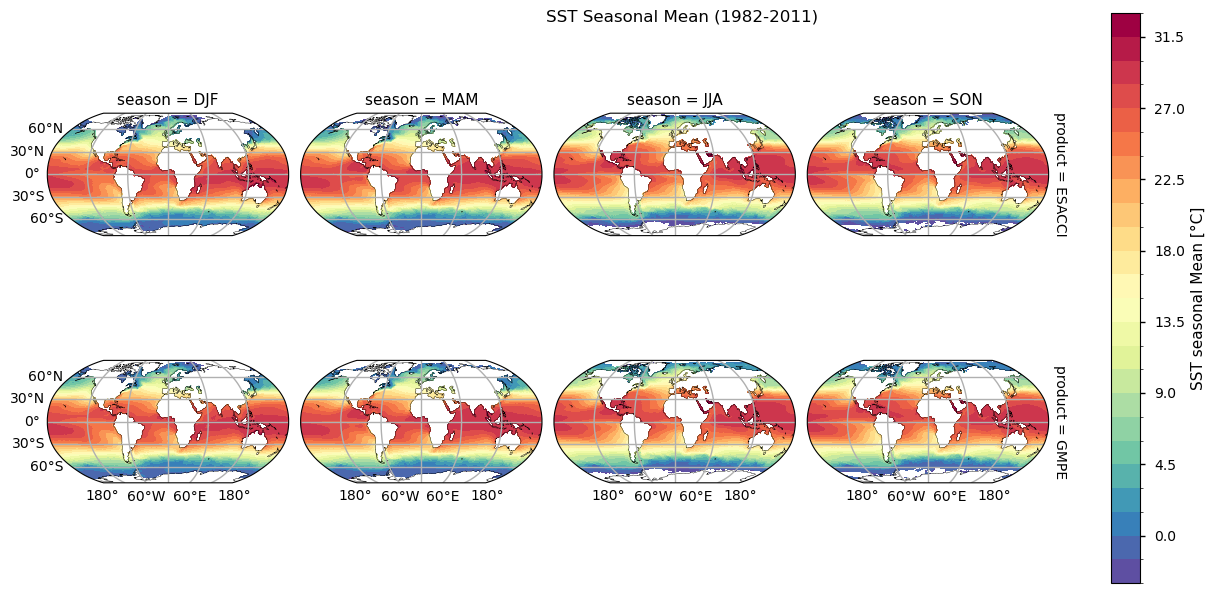

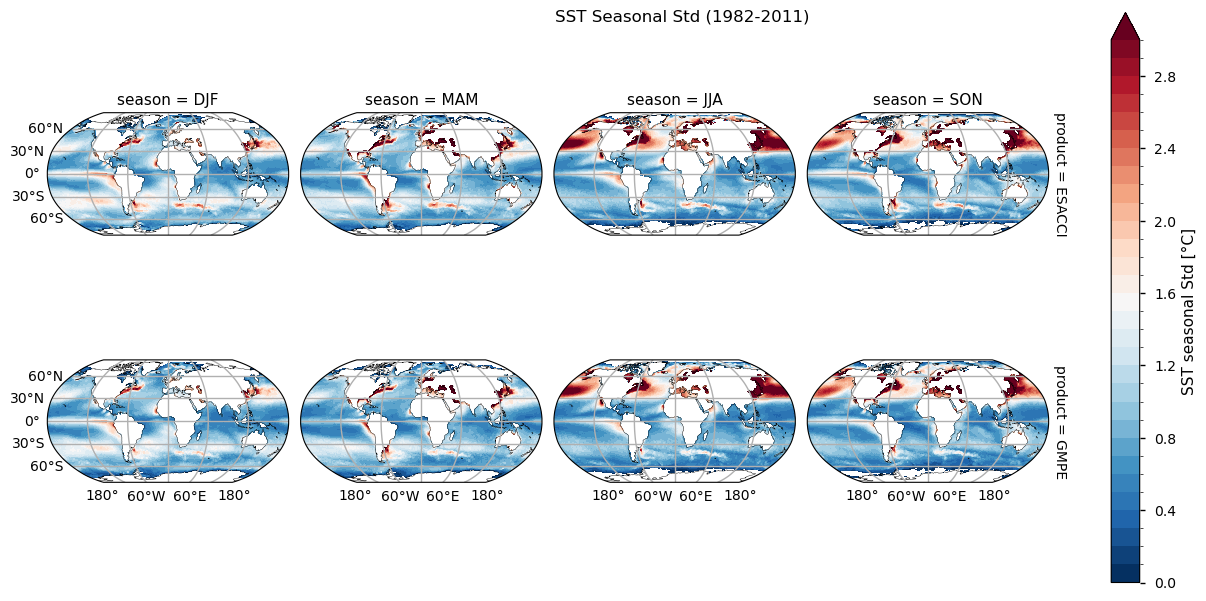

In [11]:
datasets = []
for product, ds in datasets_seasonal.items():
    if product == "ESACCI":
        ds = ds.coarsen(latitude=5, longitude=5).mean()
        ds["latitude"] = ds["latitude"].round(3)
        ds["longitude"] = ds["longitude"].round(3)
    datasets.append(ds.expand_dims(product=[product]))
ds = xr.concat(datasets, "product")

for reduction, da in ds["analysed_sst"].groupby("reduction"):
    title = f"SST Seasonal {reduction.title()} ({year_start}-{year_stop})"
    kwargs = {"projection": ccrs.Robinson(), "plot_func": "contourf", "cbar_kwargs": {'label':f"SST seasonal {reduction.title()} [{da.attrs['units']}]"}}

    # Reduction
    plot.projected_map(
        da if reduction == "mean" else da,
        cmap="Spectral_r" if reduction == "mean" else "RdBu_r",
        center=False,
        levels=31,
        vmin=None if reduction == "mean" else 0.,
        vmax=None if reduction == "mean" else 3.0,
        col="season",
        row="product",
        **kwargs,
    )
    plt.suptitle(title)
    plt.show()

    # Bias
    #with xr.set_options(keep_attrs=True):
    #    bias = da.diff("product").squeeze()
    #plot.projected_map(
    #    bias, cmap="PRGn", center=False, col="season", col_wrap=2, levels=31, vmin=-.5, vmax=.5, **kwargs
    #)
    #plt.suptitle("Bias of " + title + "\n" + " - ".join(da["product"][::-1].values))
    #plt.show()

Seasonal SST climatologies show similar patterns among the two datasets, with a warmer (cooler) Northern Hemispere during boreal summer (winter), as expected; the converse holds true for the Southern Hemisphere. It can be noticed the strong influence of major western boundary currents, such as the Gulf Stream and the Kuroshio in determining seasonal oscillations. The two dataset are found in good agreement, with the Mediterranean region being one of major hotspots for the boreal summer warming. 

Right after, we show seasonal standard deviation maps for each product. For example, the DJF map is expressed by the following formula $$\sqrt{\frac{1}{N}\sum_{i=1}^{N}\left(SST^i_{DJF} - \langle SST_{DJF}\rangle\right)^2},$$ where $N$ is the number of observations (i.e. 30 winter seasons in the present case) and $\langle SST_{DJF} \rangle$ is the average wintertime map.  
Seasonal standard deviation maps are very similar between the two products, revealing that on average the Northern Hemisphere have a much higher variability than the Southern one, with the Gulf Stream and Kuroshio dominating the patterns year round. Also, signs of high variability are noticeable in both dataset in El-Nino Region and around the Aguhlas. While the first region is a reflection of a dominant climate mode, the second one arises as a result of strong mixing and turbulence. 

## Plot timeseries

Amplitude for ESACCI 3.53, min=20.13+-0.18, max=23.66+-0.2,  228, 43
Amplitude for GMPE 3.51, min=20.27+-0.12, max=23.79+-0.18,  231, 44


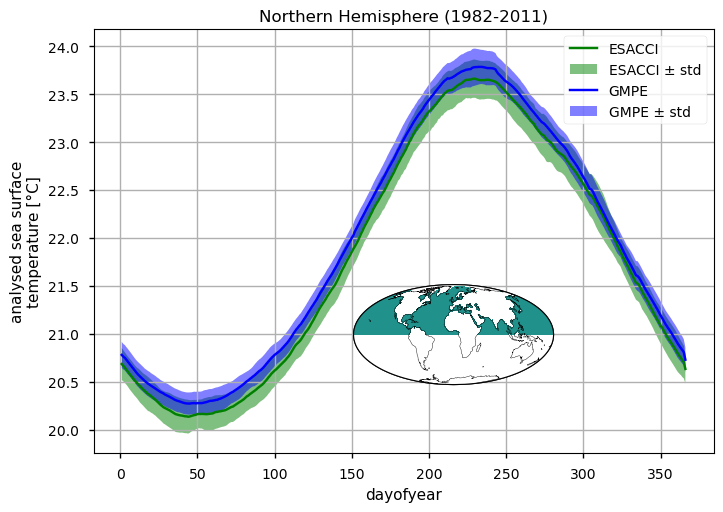

Amplitude for ESACCI 2.26, min=16.81+-0.095, max=19.07+-0.15,  70, 234
Amplitude for GMPE 2.17, min=16.86+-0.098, max=19.03+-0.14,  70, 235


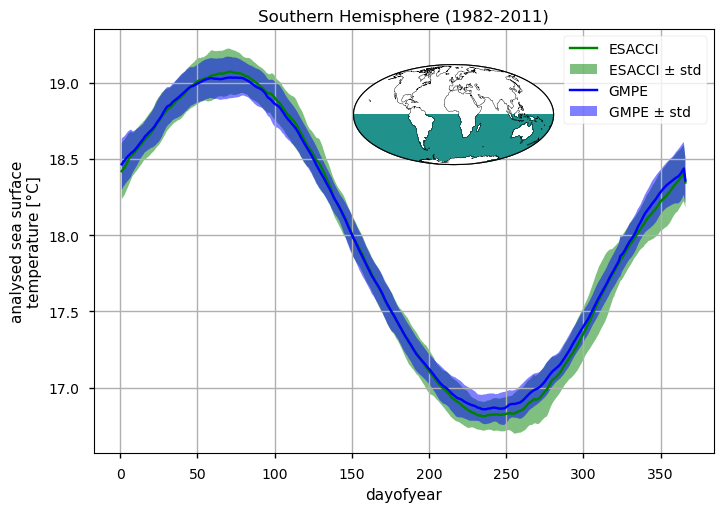

In [12]:
reg1_latmax, reg1_latmin, reg1_lonmax, reg1_lonmin = 90, 0, 180, -180
reg2_latmax, reg2_latmin, reg2_lonmax, reg2_lonmin = 0, -90, 180, -180
left1, bottom1, width1, height1 = [0.45, 0.2, 0.25, 0.25]
left2, bottom2, width2, height2 = [0.45, 0.6, 0.25, 0.25]
reg_extremes = [[reg1_latmax, reg1_latmin, reg1_lonmax, reg1_lonmin], [reg2_latmax, reg2_latmin, reg2_lonmax, reg2_lonmin]]
locations = [[left1, bottom1, width1, height1],[left2, bottom2, width2, height2]]
i=0
for region, da_region in ds_timeseries["analysed_sst"].groupby("region"):
    reg_latmax, reg_latmin, reg_lonmax, reg_lonmin = reg_extremes[i]
    mute_map = ds['analysed_sst'].isel(season=0).sel(latitude=slice(reg_latmin, reg_latmax), longitude=slice(reg_lonmin, reg_lonmax)).drop('season')
    reg_mask = xr.where(~np.isnan(mute_map), 1, np.nan).isel(product=1, reduction=1)
    left, bottom, width, height = locations[i]
    fig, ax = plt.subplots()
    ax.set_prop_cycle(color=["green", "blue"])
    for product, da_product in da_region.groupby("product"):
        mean = da_product.sel(reduction="mean")
        std = da_product.sel(reduction="std")
        mean.plot(hue="product", ax=ax, label=product, add_legend=False)
        ax.fill_between(
            da_product["dayofyear"],
            mean - std,
            mean + std,
            alpha=0.5,
            label=f"{product.upper()} ± std",
        )
        print(f"Amplitude for {mean.product.values} {mean.max().values-mean.min().values:.3}, min={mean.min().values:.4}+-{std[np.argmin(mean.values)].values:.2}, max={mean.max().values:.4}+-{std[np.argmax(mean.values)].values:.2},  {np.argmax(mean.values)}, {np.argmin(mean.values)}")
        ax2 = fig.add_axes([left, bottom, width, height], projection=ccrs.Mollweide())
        ax2.set_global()
        p2 = reg_mask.plot.contourf(ax=ax2, transform=ccrs.PlateCarree(), add_colorbar=False)
        ax2.coastlines()
        ax2.set_title('')
        ax.set_title(f"{region.title()} ({year_start}-{year_stop})")
    ax.legend()
    ax.grid()
    plt.show()
    i+=1

The above figure is the spatial average of the climatological year for the period 1982-2011 for each product in the Northern (top panel) and Southern (bottom panel) Hemisphere: ESACCI in green and GMPE in blue. The shading represents the variance along the given day of the year.

The Northern Hemisphere exhibits an SST annual cycle characterized by an amplitude of about $3.5$ degrees for both datasets (GMPE=$3.51^oC$;  ESACCI=$3.53^oC$). Minimum and maximum mean SSTs are observed during the second half of February (GMPE=$20.27 \pm 0.12 ^oC$ and ESACCI=$20.13 \pm 0.18 ^oC$) and in mid August (GMPE=$23.79 \pm 0.18 ^oC$ and ESACCI=$23.66 \pm 0.2 ^oC$). The Southern Hemisphere exhibits an SST annual cycle characterized by an amplitude of about $2$ degrees for both datasets (GMPE=$2.17^oC$;  ESACCI=$2.26^oC$). Maximum and minimum mean SSTs are observed during  the first half of March (GMPE=$16.86 \pm 0.098 ^oC$ and ESACCI=$16.81 \pm 0.095 ^oC$) and in late August (GMPE=$19.03 \pm 0.14 ^oC$ and ESACCI=$19.07 \pm 0.15 ^oC$). 
The overall SST variability is higher in correspondence of maxima/minima of the annual cycle.
The SST annual cycle amplitude differs by $1.5 ^oC$ between the Northern and the Southern Hemisphere. This behavior is in agreement with observational data from the World Ocean Atlas data as shown in figure 3 of (Griffies et al. 2014)

#### ***Some References***
- *Deser, C., Alexander, M. A., Xie, S. P., & Phillips, A. S. (2010). Sea surface temperature variability: Patterns and mechanisms. Annual review of marine science, 2, 115-143.*

- *Griffies, S. M., Winton, M., Anderson, W. G., Benson, R., Delworth, T. L., Dufour, C. O., ... & Zhang, R. (2015). Impacts on ocean heat from transient mesoscale eddies in a hierarchy of climate models. Journal of Climate, 28(3), 952-977.*